# Introduction
This implements the iterative classification algorithm as described in slide 37 of http://web.stanford.edu/class/cs224w/slides/05-message.pdf  
It classifies a node based on its features as well as labels of neighbours

## Definitions
$v$: Node  
$Y_v$: Labels of node $v$  
$f_v$: feature vector of node $v$  
$z_v$: summary of labels of $v$'s neighbours (a vector)  
$\phi_1(f_v)$: predict node label based on node feature vector $f_v$  
$\phi_2(f_v, z_v)$: predict label based on node feature vector $f_v$ of labels of $v$'s neighbours

## Phase 1: Train a Classifier based on node attributes only
The classifier can be linear classifier, neural network classifier etc. This is trained on the training set to predict the labels for each node.

$\phi_1(f_v)$ : to predict $Y_v$ based on $f_v$  
$\phi_2(f_v, z_v)$ to predict $Y_v$ based on $f_v$ and summary $z_v$ of labels of $v$'s neighbours  
For vector $z_v$ of neighbourhood labels, let

- $L$ = neighbour label info vector  
  $L1\text{_Max}$: Max edge weight of all node's neighbors who are cheaters  
  $L0\text{_Max}$: Max edge weight of all node's neighbors who are non-cheaters
  $L1\text{_Mean}$: Mean edge weight of all node's neighbors who are cheaters  
  $L0\text{_Mean}$: Mean edge weight of all node's neighbors who are non-cheaters

## Phase 2: Iterate till Convergence

On the test set, set the labels based on the classifier in Phase 1,

## Step 1: Train Classifier

On a different training set, train two classifiers:

- node attribute vector only: $\phi_1$
- node attribute and link vectors: $\phi_2$

## Step 2: Apply Classifier to test set

On test set, use trained node feature vector classifier $\phi_1$ to set $Y_v$

## Step 3.1: Update relational vectors z

Update $z_v$ for all nodes on test set

## 3.2: Update Label

Reclassify all nodes with $\phi_2$

## Iterate

Continue until convergence

- update $z_v$
- update $Y_v = \phi_2(f_v, z_v)$

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
while Path.cwd().name != 'bayesian_beats_cheats':
    os.chdir(Path.cwd().parent)

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from collective.constants import add_nodes_edges_to_graph, get_prec_at_k, get_df
from collective.Iterative import IterativeClassification

import matplotlib.pyplot as plt
from src.visualization import make_confusion_matrix, parse_results


In [2]:
cols_to_scale = ["t01_exp", "t02_exp", "t03_exp", "t04_exp", "t05_exp", "t06_exp", "t07_exp", "t08_exp", "t09_exp", "t10_exp", "num_videos"]

def train_lr(X_combine, y_combine, COMBINE, df_edge, X_test, y_test, gamma='scale', degree=3, C=1.0, kernel='rbf'):
    print("Training model1")

    scaler = MinMaxScaler()
    X_combine[cols_to_scale] = scaler.fit_transform(X_combine[cols_to_scale])
    COMBINE[cols_to_scale] = scaler.fit_transform(COMBINE[cols_to_scale])
    X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

    model = SVC(class_weight="balanced", gamma=gamma, degree=degree, C=C, kernel=kernel, probability=True)
    model1 = model
    model1.fit(X_combine.drop(columns=['name']), y_combine)

    network_graph_combine, df_combine = add_nodes_edges_to_graph(COMBINE, df_edge)

    # use predicted labels from model1
    y_pred = model1.predict(X_test.drop(columns=['name']))
    TEST = pd.concat([X_test, pd.Series(y_pred, index=X_test.index, name='label')], axis='columns')

    network_graph_test, df_test = add_nodes_edges_to_graph(TEST, df_edge)

    model2 = SVC(class_weight="balanced", gamma=gamma, degree=degree, C=C, kernel=kernel, probability=True)
    model2.fit(df_combine.drop(['label'], axis=1), df_combine['label'])

    iter_class = IterativeClassification()
    network_graph_test, df_test = iter_class.iterate(network_graph_test, model1, model2, df_test)
    f1 = f1_score(y_test, df_test['label'])
    return [network_graph_test, df_test, model2, f1]

def val_lr(X_combine, y_combine, COMBINE, df_edge, gamma='scale', degree=3, C=1.0, kernel='rbf'):
    skf = StratifiedKFold(n_splits=3, random_state=0)
    f1_scores = np.array([])
    for train_index, test_index in skf.split(X, y):
        X_train, X_val = X_combine[train_index], X_combine[test_index]
        y_train, y_val = y_combine[train_index], y_combine[test_index]
        TRAIN_COMBINE = pd.concat([X_train, y_train], axis="columns")

        network_graph_test, df_test, model2, f1 = train_lr(X_train, y_train, TRAIN_COMBINE, df_edge, X_val, y_val, gamma=gamma, degree=degree, C=C, kernel=kernel)
        f1_scores = np.append(f1_scores, f1)
    return f1_scores.mean()

In [3]:
%%time

X_train, y_train, df_edge, X_val, y_val, X_test, y_test = get_df('data/imputed_unified_node_data.csv', 'data/max_edge_weights.csv')

X_combine = pd.concat([X_train, X_val], axis='index')
y_combine = pd.concat([y_train, y_val], axis='index')

COMBINE = pd.concat([X_combine, y_combine], axis='columns')
VAL_COMBINE = pd.concat([X_val, y_val], axis='columns')

Class distributions: 
0    614
1    102
Name: label, dtype: int64

Clipping edge weights and num_videos
Wall time: 49 ms


In [4]:
gammas = [0.001, 0.0001, 0.00001]
cs = [1, 0.1, 0.01, 0.001]
degrees = [1, 3, 5, 10, 15]
max_f1 = 0
params = {}

for gamma in gammas:
    for c in cs:
        print(f"Validating with the values: gamma={gamma}, degree=3, C={c}, kernel=linear")
        network_graph_test, df_test, model2, f1 = train_lr(X_train, y_train, VAL_COMBINE, df_edge, X_val, y_val, gamma=gamma, degree=3, C=c, kernel='linear')
        if f1 > max_f1:
            max_f1 = f1
            params['kernel'] = 'linear'
            params['gamma'] = gamma
            params["degree"] = 3
            params["C"] = c

for gamma in gammas:
    for degree in degrees:
        for c in cs:
            print(f"Validating with the values: gamma={gamma}, degree={degree}, C={c}, kernel=poly")
            network_graph_test, df_test, model2, f1 = train_lr(X_train, y_train, VAL_COMBINE, df_edge, X_val, y_val, gamma=gamma, degree=degree, C=c, kernel='poly')
            if f1 > max_f1:
                max_f1 = f1
                params['kernel'] = 'poly'
                params['gamma'] = gamma
                params["degree"] = degree
                params["C"] = c

kernels = ['rbf', 'sigmoid']
for kernel in kernels:
    for gamma in gammas:
        for c in cs:
            print(f"Validating with the values: gamma={gamma}, degree=3, C={c}, kernel={kernel}")
            network_graph_test, df_test, model2, f1 = train_lr(X_train, y_train, VAL_COMBINE, df_edge, X_val, y_val, gamma=gamma, degree=3, C=c, kernel=kernel)
            if f1 > max_f1:
                max_f1 = f1
                params['kernel'] = kernel
                params['gamma'] = gamma
                params["degree"] = 3
                params["C"] = c

print(f"Max avg f1 score of {f1} achieved on val set with the parameters: gamma={gamma}, degree={degree}, C={c}, kernel={kernel}")

Validating with the values: gamma=0.001, degree=3, C=1, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.001, degree=3, C=0.1, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.001, degree=3, C=0.01, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.001, degree=3, C=0.001, kernel=linear
Training model1
converged in 1 iterations
Validating with the values: gamma=0.0001, degree=3, C=1, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.0001, degree=3, C=0.1, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.0001, degree=3, C=0.01, kernel=linear
Training model1
converged in 2 iterations
Validating with the values: gamma=0.0001, degree=3, C=0.001, kernel=linear
Training model1
converged in 1 iterations
Validating with the values: gamma=1e-05, degree=3, C=1, kernel=linear
Training mod

Training model1
converged in 2 iterations
d:\University\Masters\Y2 Sem 2\CS5340\Project\bayesian_beats_cheats\src\visualization.py:115: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cf[1, 1] / sum(cf[:, 1])


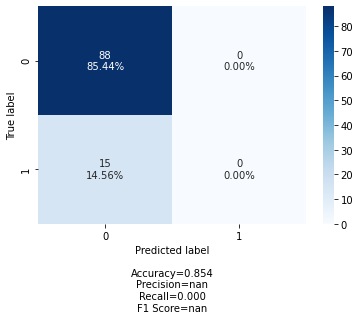


Precision @ 5: 0.4
Precision @ 10: 0.5
Precision @ 15: 0.4
Wall time: 2.72 s


In [5]:
%%time

network_graph_test, df_test, model2, f1 = train_lr(X_combine, y_combine, COMBINE, df_edge, X_test, y_test, gamma=params["gamma"], degree=params["degree"], C=params["C"], kernel=params["kernel"])

parse_results(proba=model2.predict_proba(df_test.drop(['label'], axis=1))[:, 1], true_labels=y_test)